# Temperature and Salinity at Depth Levels

Goals of this notebook:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of T/S fields at depth levels and compared agains observations (WOA18).

Temprature and salinity comparisons (model vs obs) at selected depth levels are grouped into the following regions: Global, Antarctic, and Arctic.

In [1]:
%matplotlib inline
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xycompare, polarcomparison
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools import m6toolbox
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import yaml, intake, os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore")

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

# load avg dates
avg = diag_config_yml['Avg']

# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
DOUT_S = dcase.get_value('DOUT_S')
if DOUT_S:
  OUTDIR = dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = dcase.get_value('RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', dcase.casename)

Output directory is: /glade/scratch/gmarques/archive/g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001/ocn/hist/
Casename is: g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001


In [3]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = dcase.casename
args.obs = "woa-2018-tx2_3v2-annual-all"
args.monthly = dcase.casename+diag_config_yml['Fnames']['z']
args.static = dcase.casename+diag_config_yml['Fnames']['static']
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [4]:
# load mom6 grid
grd = MOM6grid(OUTDIR+args.static)
grd_xr = MOM6grid(OUTDIR+args.static, xrformat=True)

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



In [5]:
parallel = False
if args.nw > 1:
  parallel = True
  cluster = NCARCluster()
  cluster.scale(args.nw)
  client = Client(cluster)
  client

In [17]:
client

<Client: No scheduler connected>

In [7]:
# load history files

def preprocess(ds):
    ''' Return a dataset desired variables'''
    variables = ['thetao', 'so', 'time', 'time_bounds']
    return ds[variables]

ds = xr.open_mfdataset(OUTDIR+args.monthly, \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [8]:
# Select data
%time 
ds_sel = ds.sel(time=slice(args.start_date, args.end_date))

CPU times: user 8.46 ms, sys: 66 µs, total: 8.53 ms
Wall time: 10.9 ms


In [9]:
# compute annual mean and then average in time
ds_ann = m6toolbox.weighted_temporal_mean_vars(ds_sel)

In [10]:
thetao_mean = ds_ann.thetao.mean('time')
temp = np.ma.masked_invalid(thetao_mean.values)

In [11]:
so_mean = ds_ann.so.mean('time')
salt = np.ma.masked_invalid(so_mean.values)

In [12]:
# load WOA18 data
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
woa18 = catalog[args.obs].to_dask()
woa18 = woa18.rename({'z_l' : 'depth'});

In [13]:
print('Saving netCDF files...')

if not os.path.isdir('ncfiles'):
      os.system('mkdir -p ncfiles')
        
attrs = {'description': 'model - obs at depth levels',
       'start_date': args.start_date,
       'end_date': args.end_date,
       'casename': dcase.casename,
       'obs': args.obs,
       }

Saving netCDF files...


In [14]:
temp_bias = np.ma.masked_invalid(thetao_mean.values - woa18.thetao.values)
ds_thetao = xr.Dataset(data_vars={ 'thetao' : (('z_l','yh','xh'), thetao_mean.values),
                                   'thetao_bias' :     (('z_l','yh','xh'), temp_bias)},
                                   coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh})
m6toolbox.add_global_attrs(ds_thetao,attrs)
ds_thetao.to_netcdf('ncfiles/'+str(dcase.casename)+'_thetao_time_mean.nc')

In [15]:
so_bias = np.ma.masked_invalid(so_mean.values - woa18.so.values)
ds_so = xr.Dataset(data_vars={ 'so' : (('z_l','yh','xh'), so_mean.values),
                            'so_bias' :     (('z_l','yh','xh'), so_bias)},
                            coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh})
m6toolbox.add_global_attrs(ds_so,attrs)
ds_so.to_netcdf('ncfiles/'+str(dcase.casename)+'_so_time_mean.nc') 

In [16]:
client.close(); cluster.close()

## Global

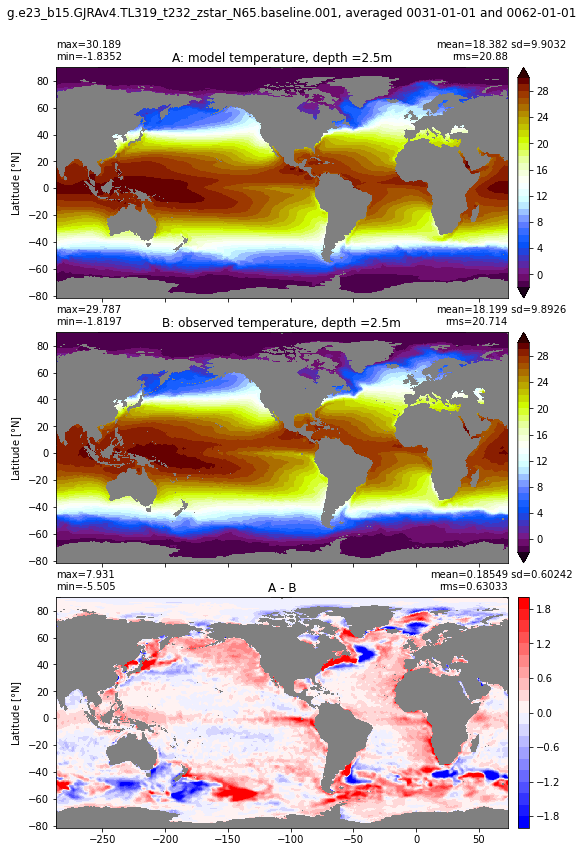

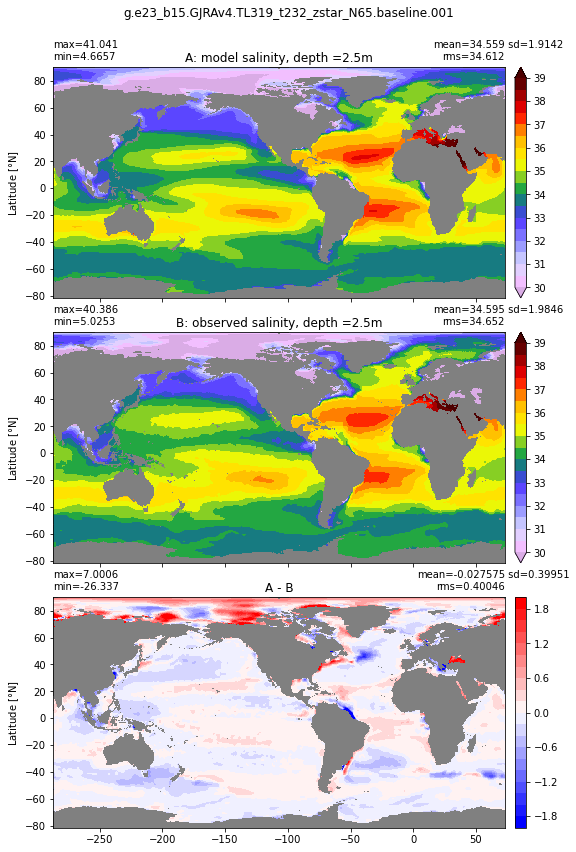

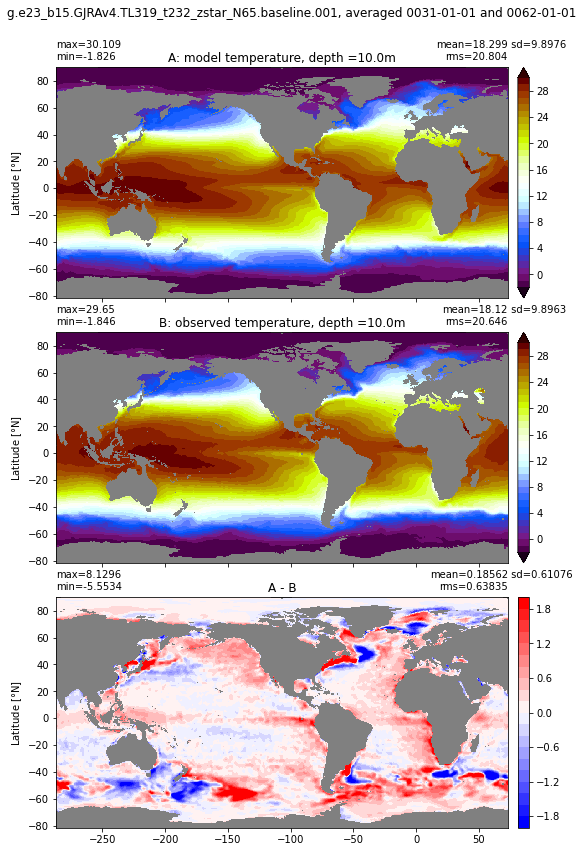

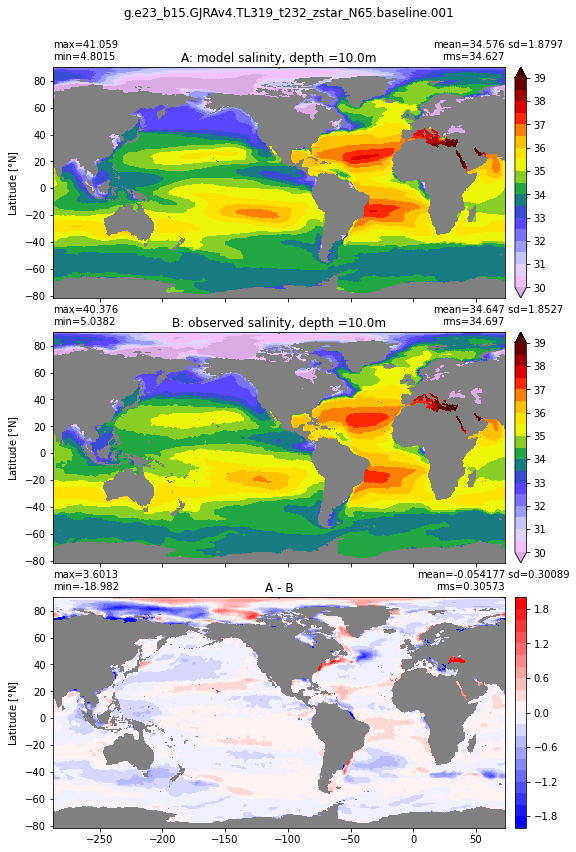

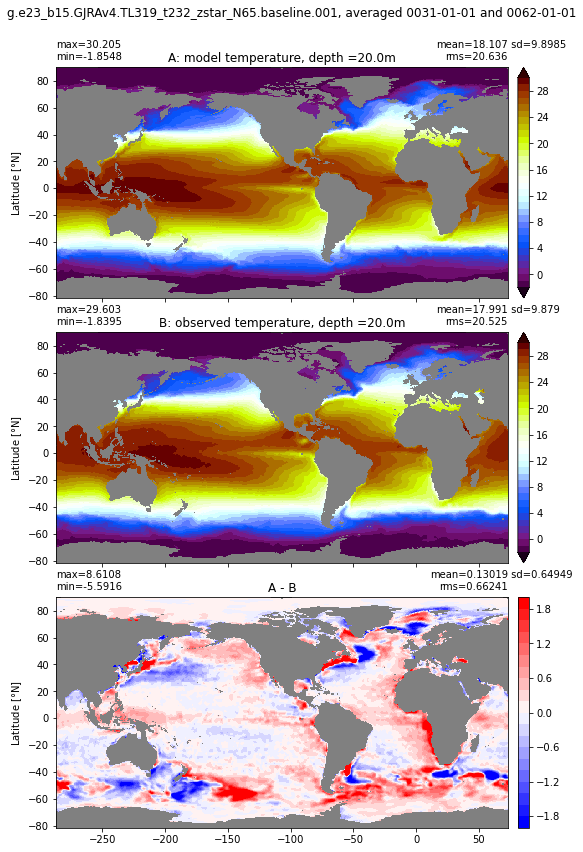

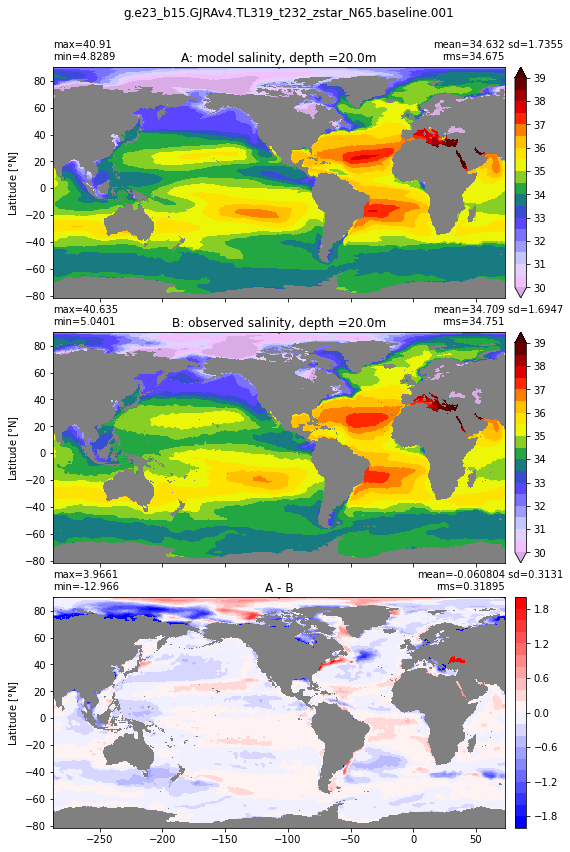

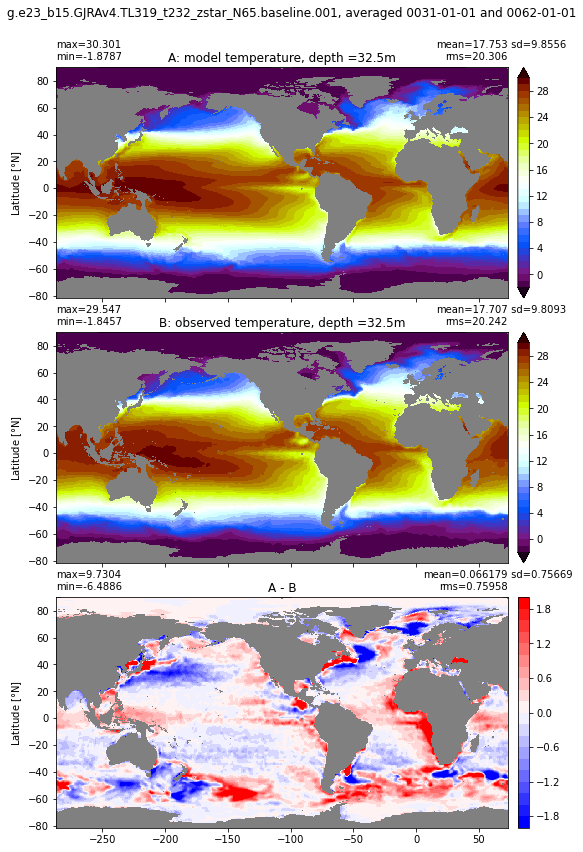

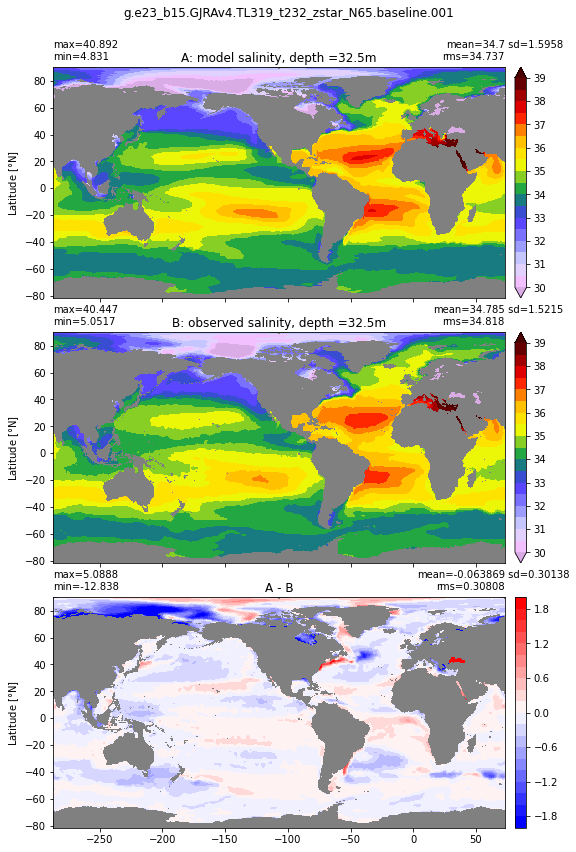

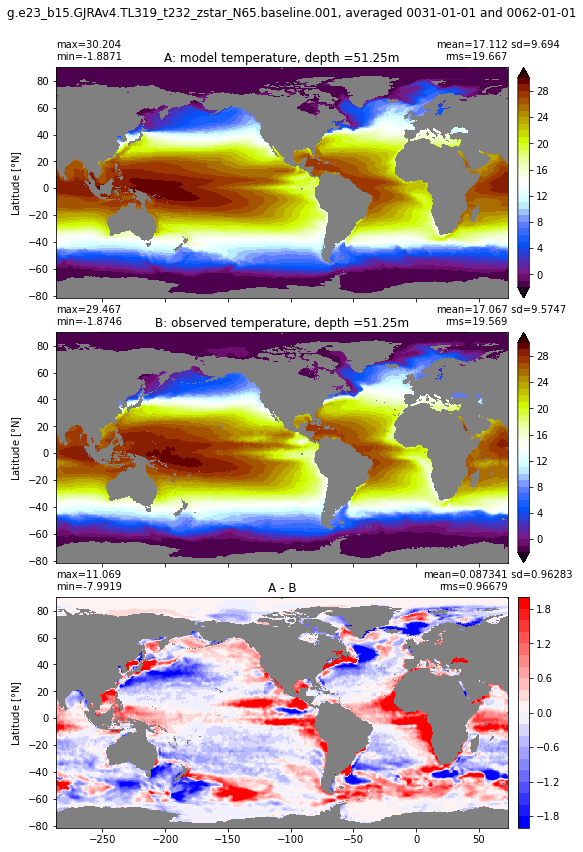

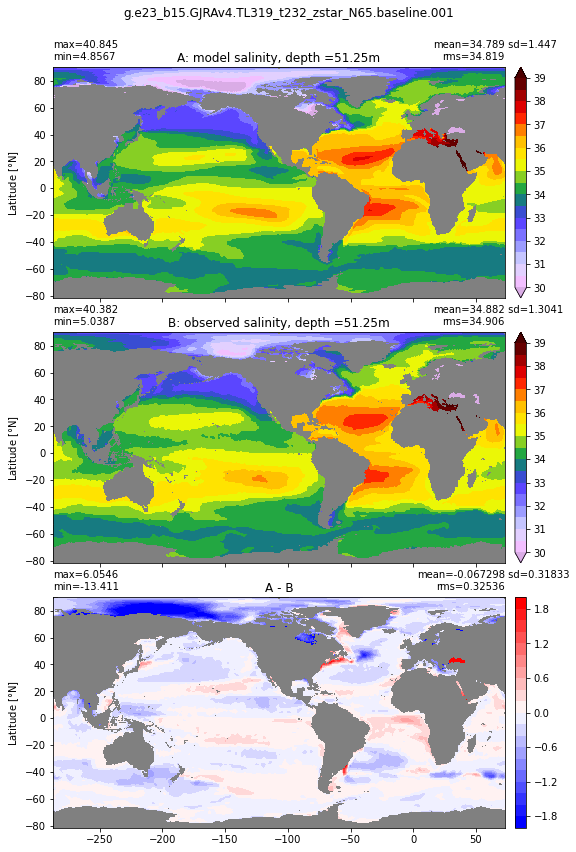

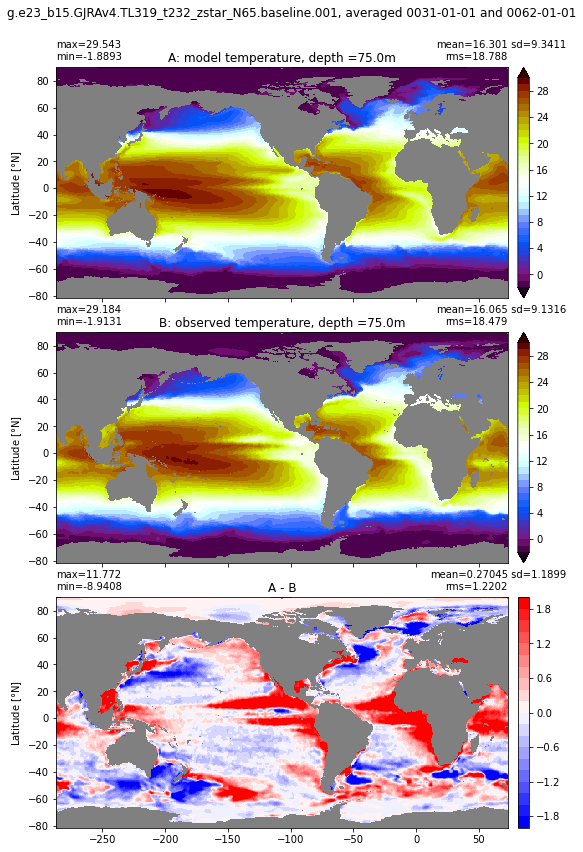

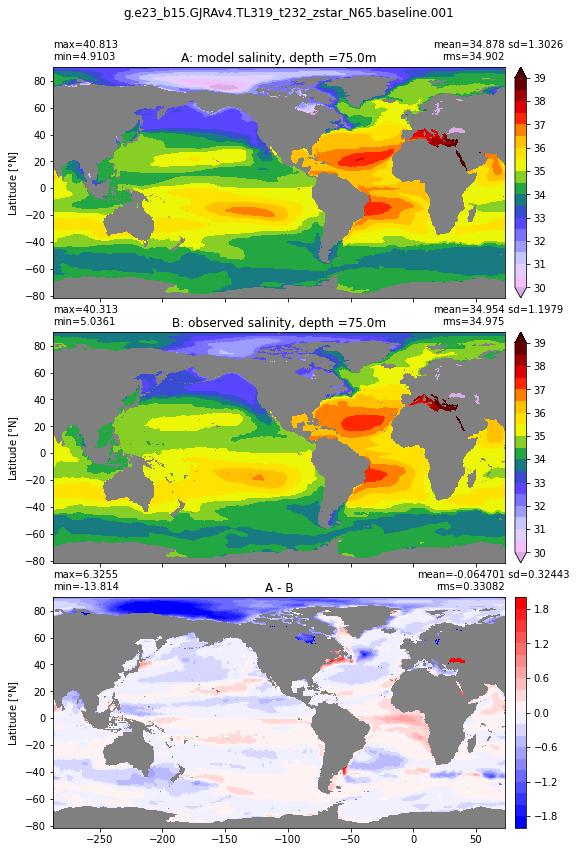

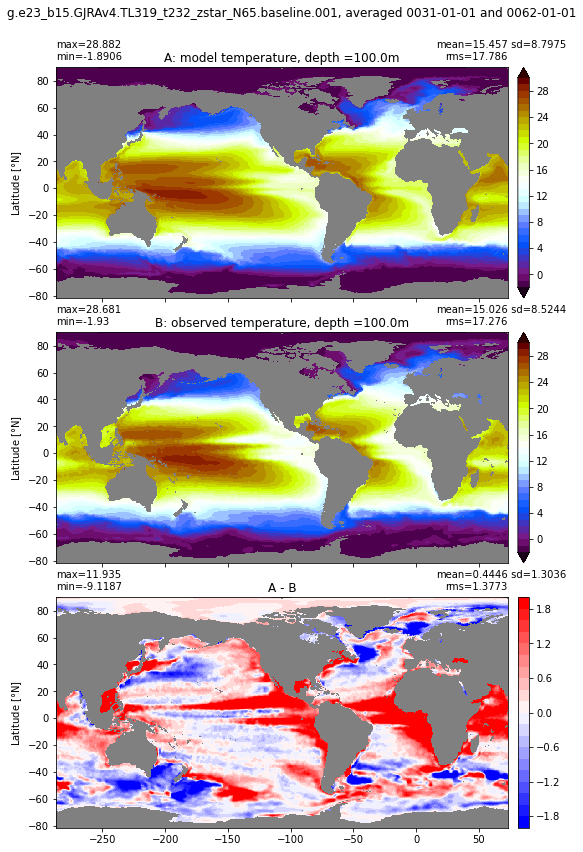

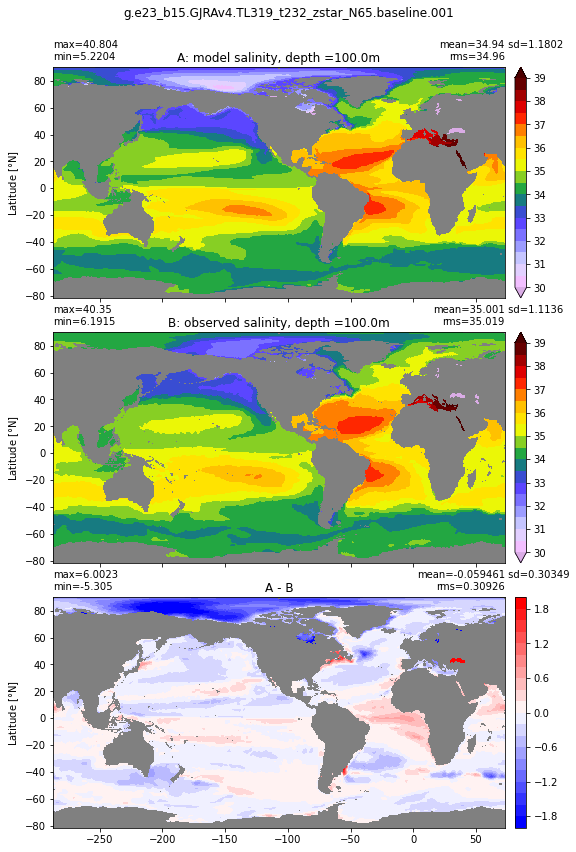

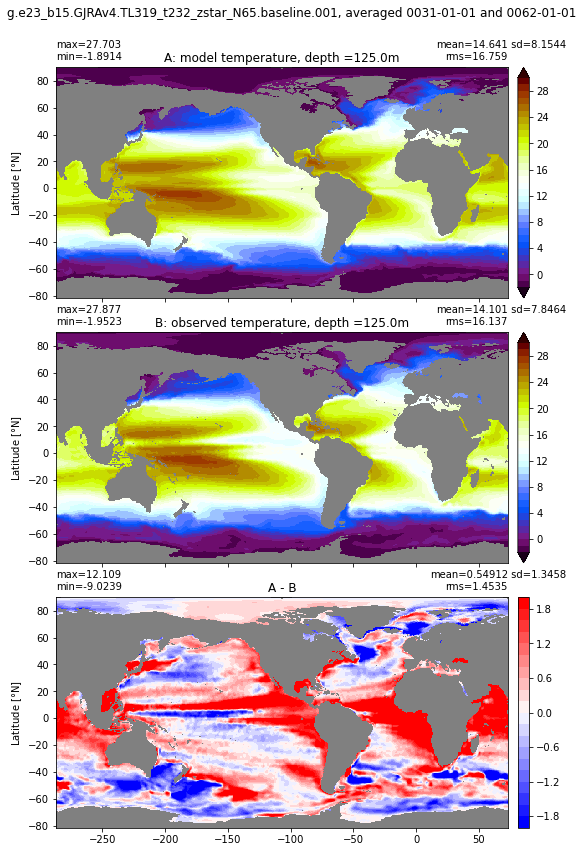

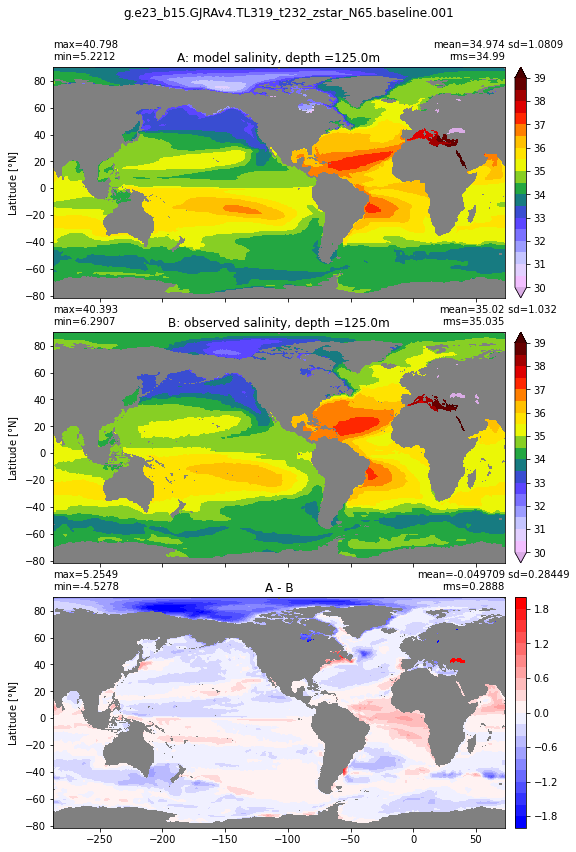

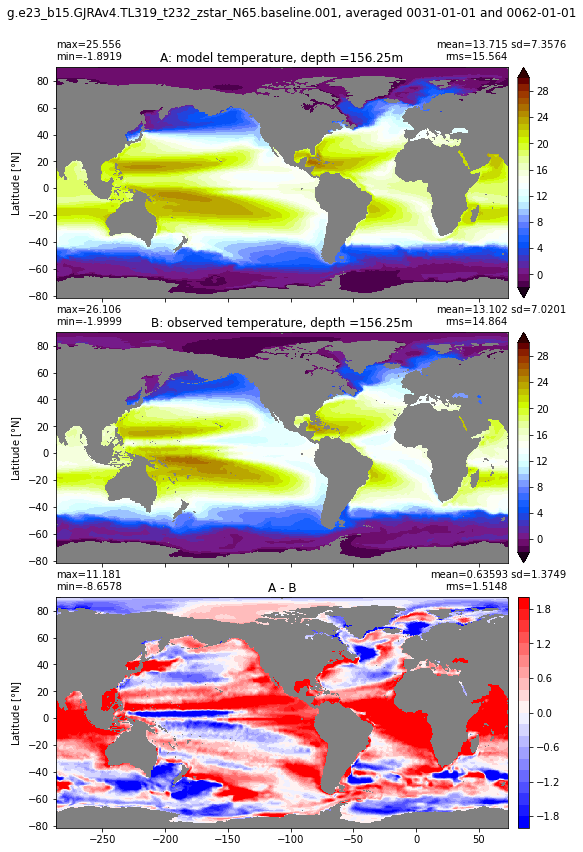

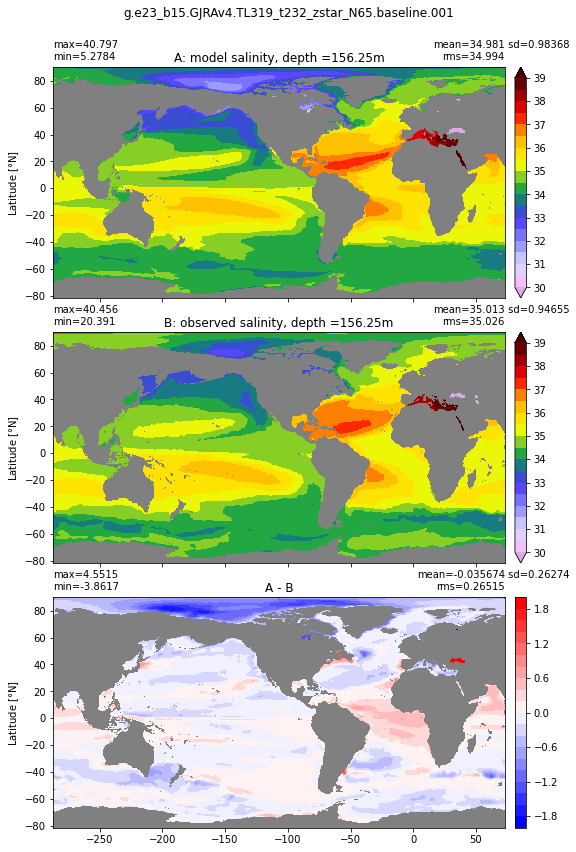

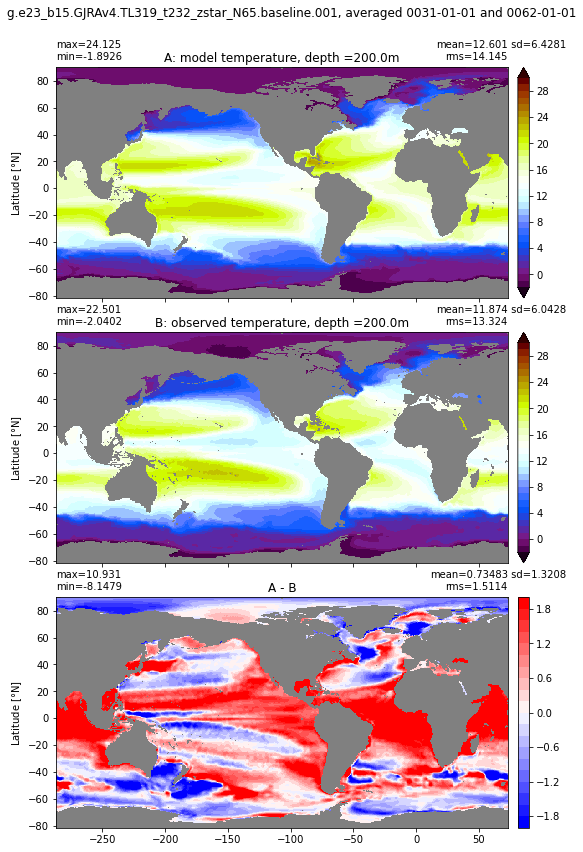

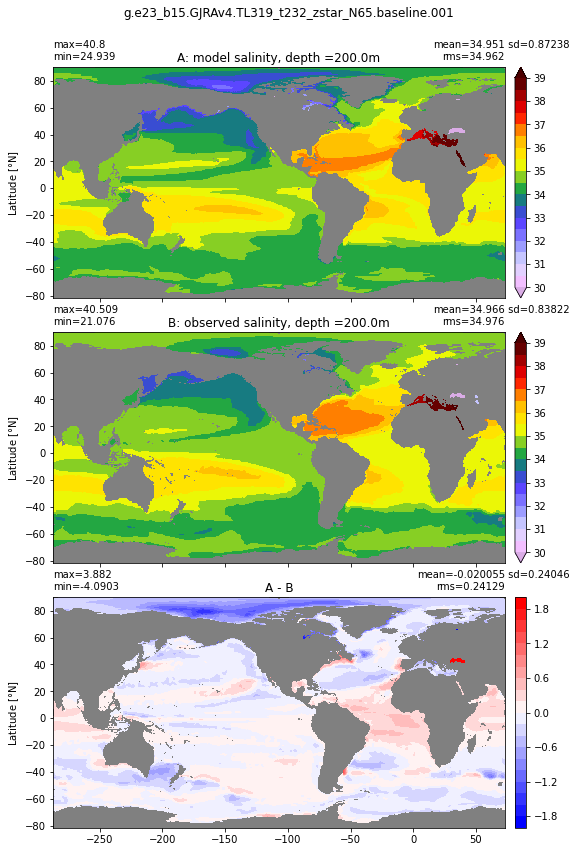

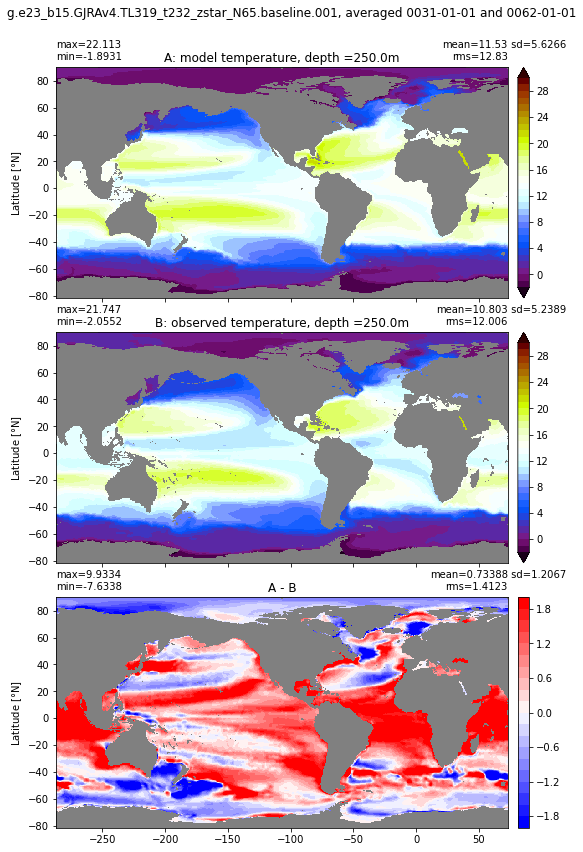

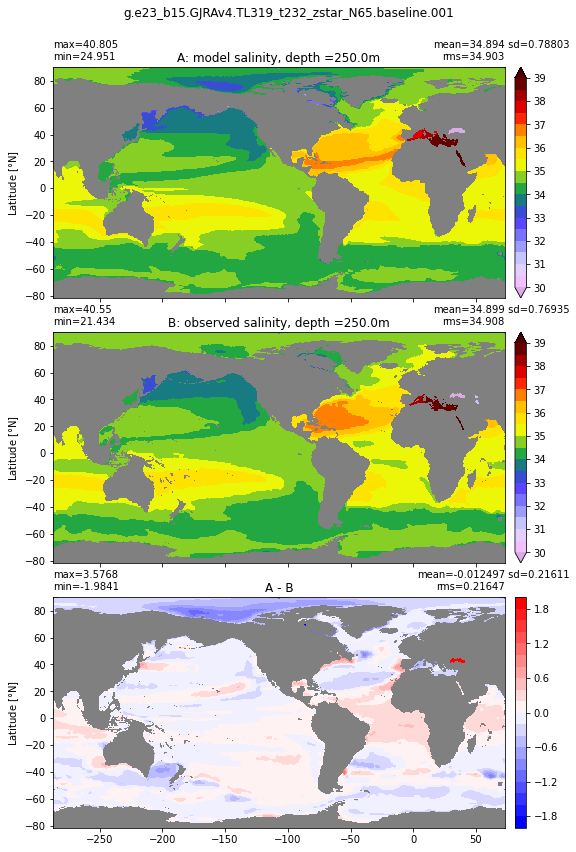

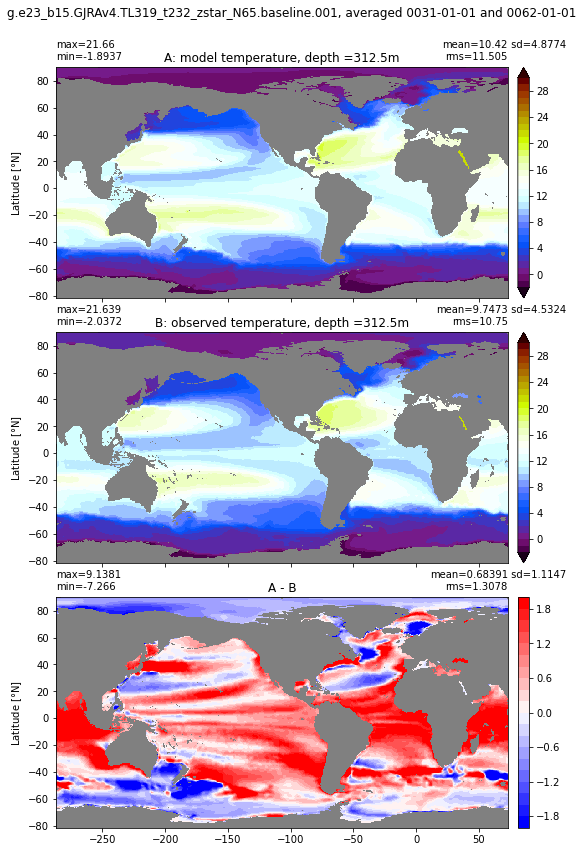

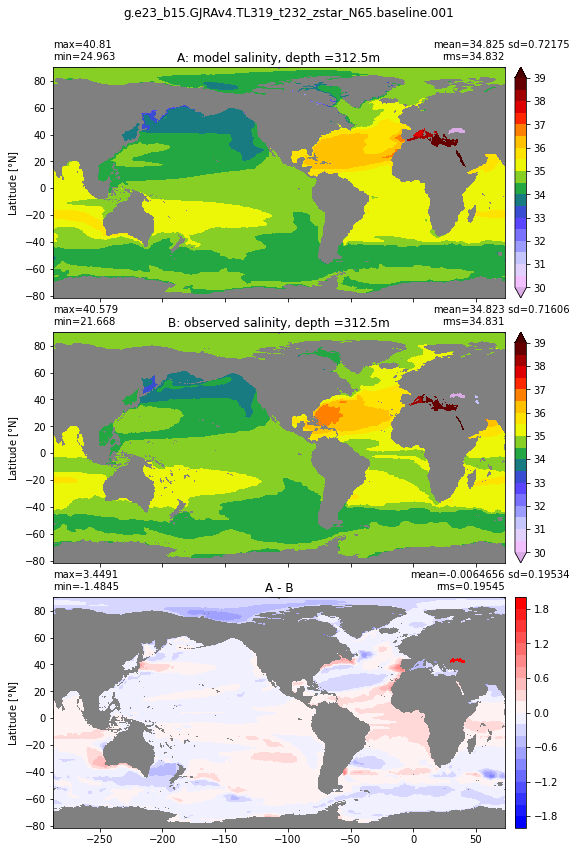

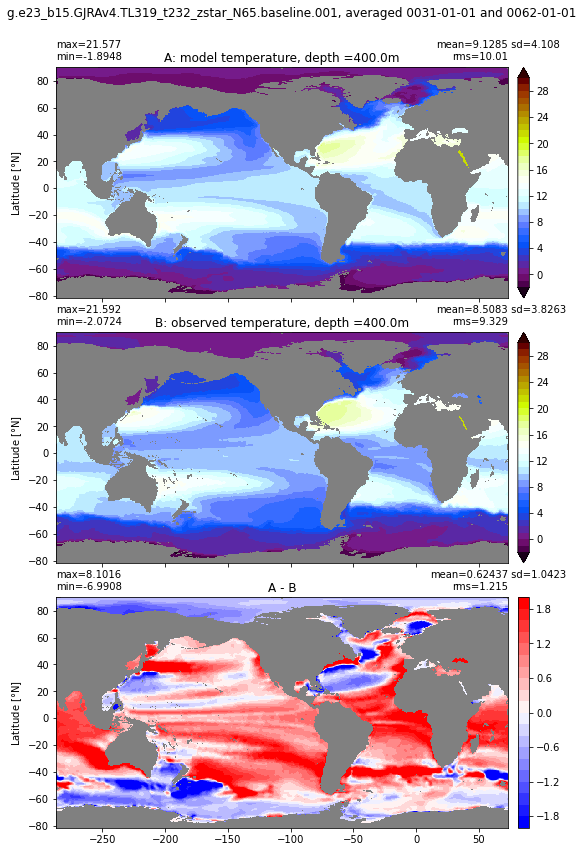

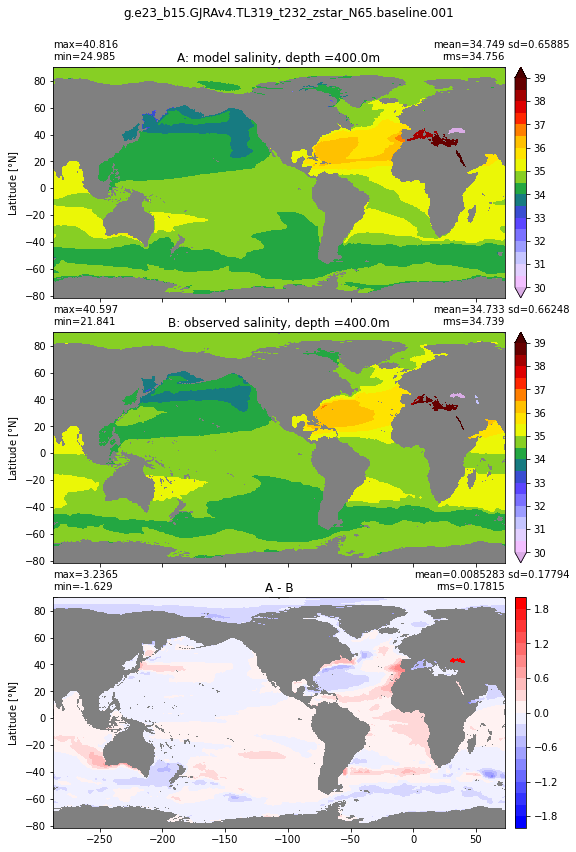

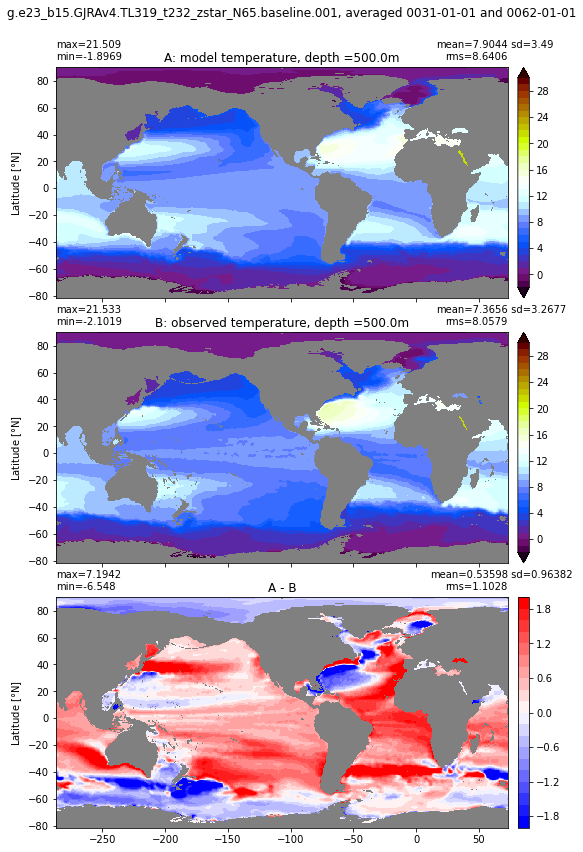

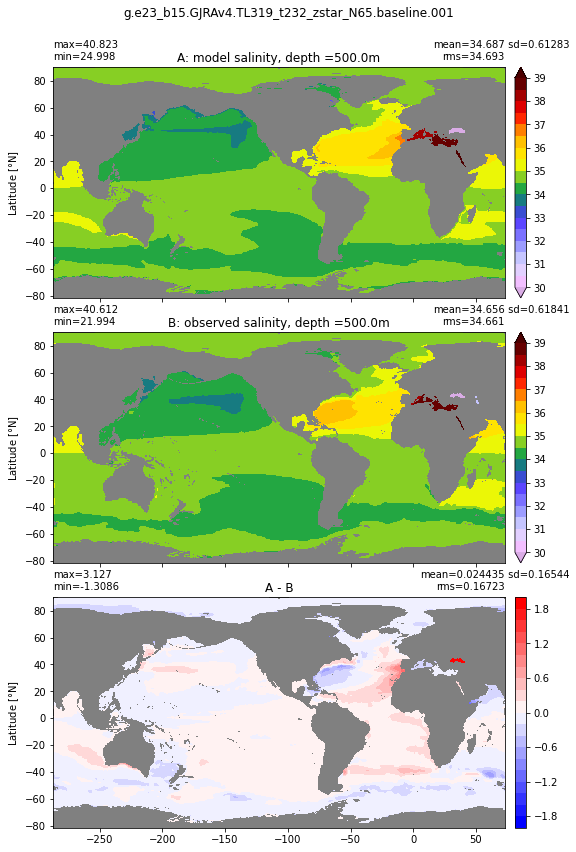

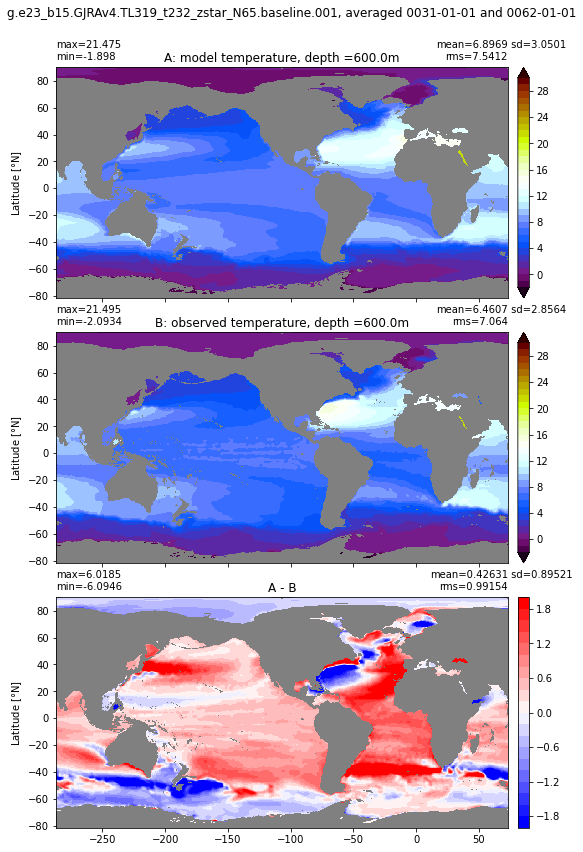

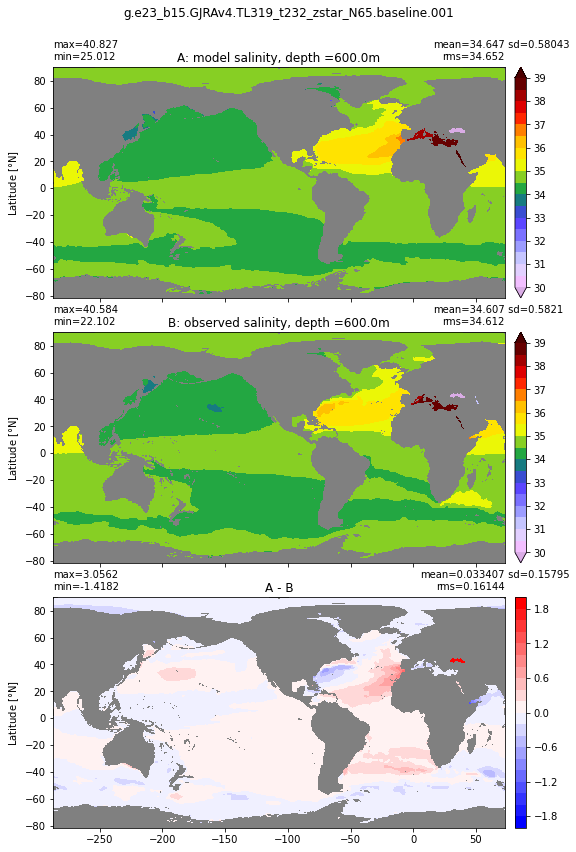

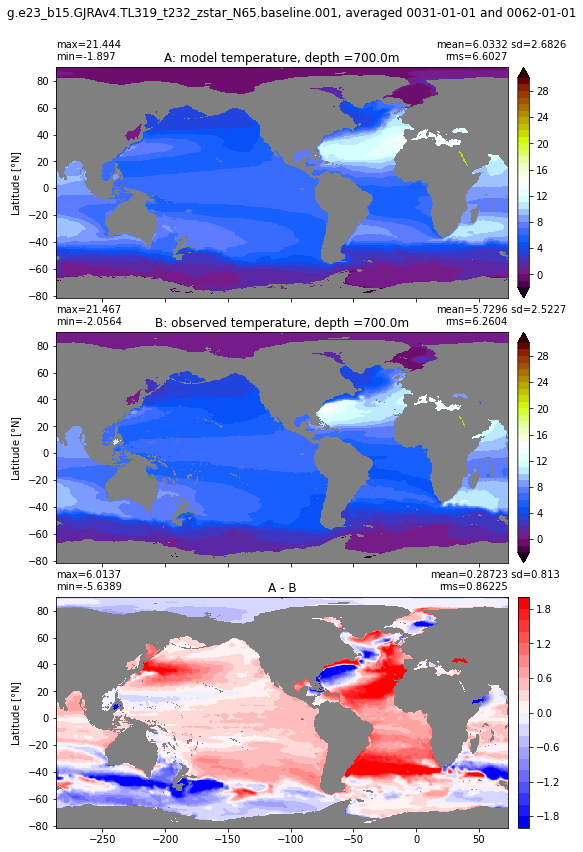

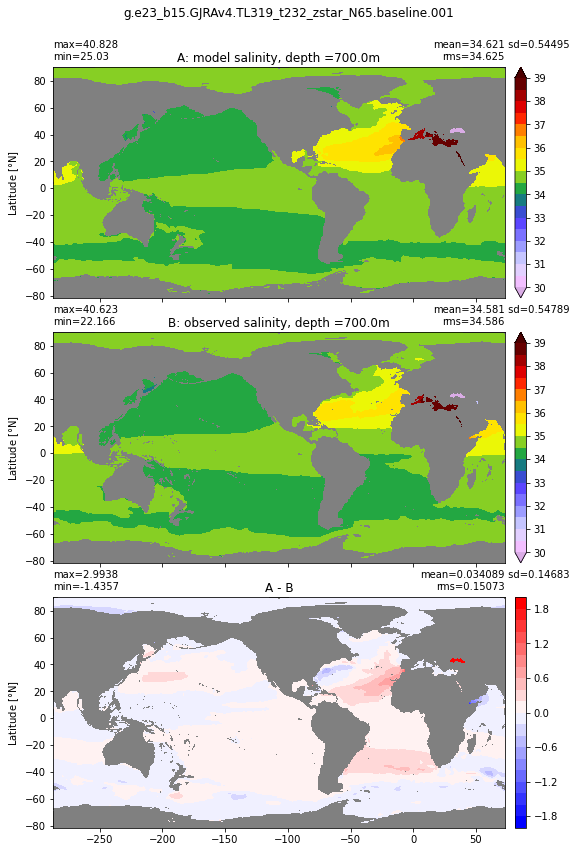

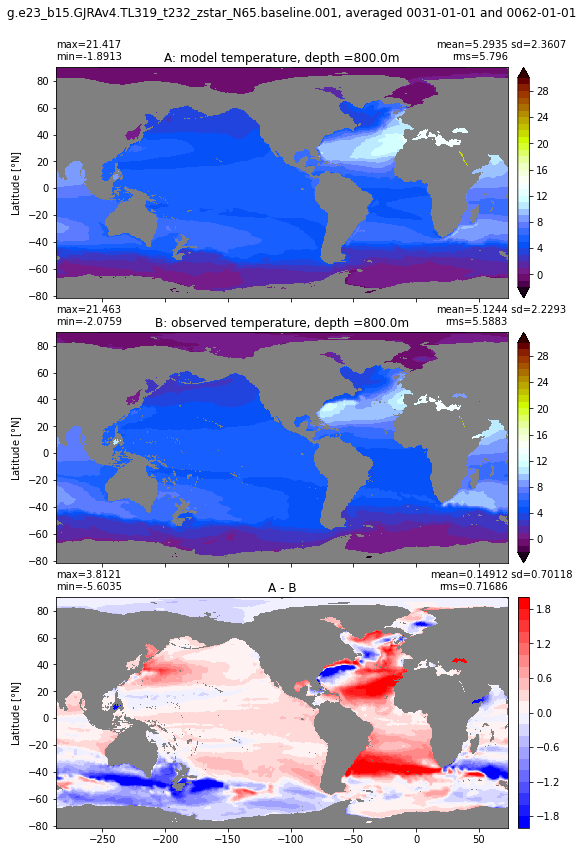

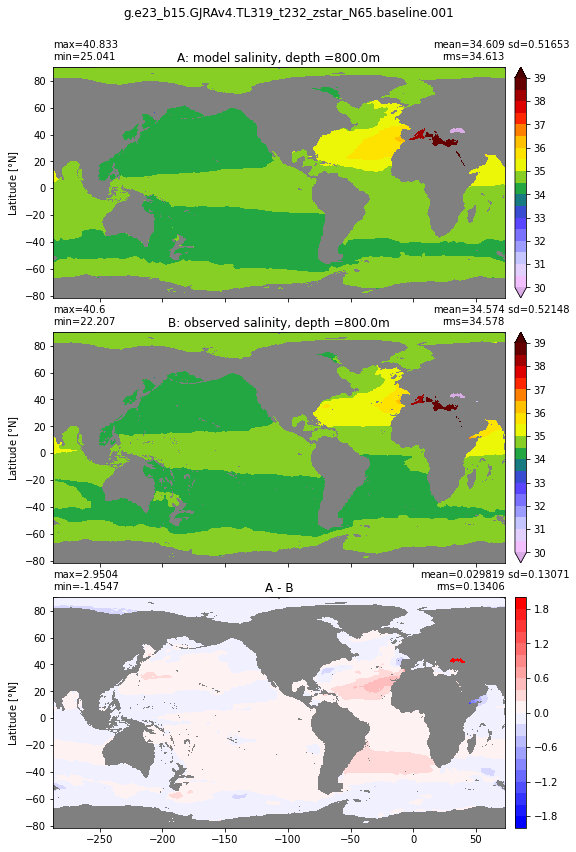

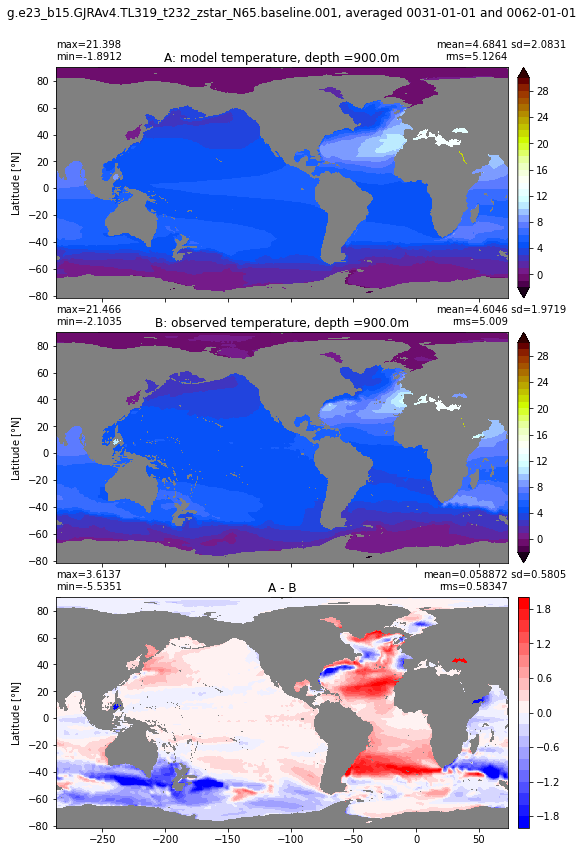

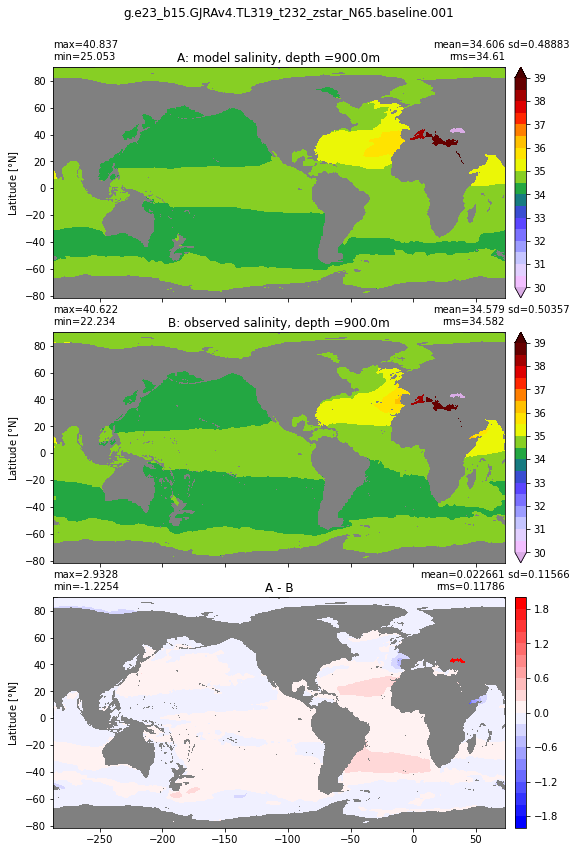

In [12]:
%matplotlib inline
km = len(woa18['depth'])
for k in range(km):
  if ds['z_l'][k].values < 1000.0:
    temp_obs = np.ma.masked_invalid(woa18['thetao'][k,:].values)
    xycompare(temp[k,:] , temp_obs, grd.geolon, grd.geolat, area=grd.areacello,
            title1 = 'model temperature, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed temperature, depth ='+str(woa18['depth'][k].values)+ 'm',
            suptitle=dcase.casename + ', averaged '+str(args.start_date)+ ' and ' +str(args.end_date),
            clim=(-1.9,30.), dcolormap=plt.cm.bwr,
            extend='both', dextend='neither', dlim=(-2,2),
            show= True)
    salt_obs = np.ma.masked_invalid(woa18['so'][k,:].values)
    xycompare( salt[k,:] , salt_obs, grd.geolon, grd.geolat, area=grd.areacello,
            title1 = 'model salinity, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed salinity, depth ='+str(woa18['depth'][k].values)+ 'm',
            suptitle=dcase.casename, clim=(30,39.), dcolormap=plt.cm.bwr,
            extend='both', dextend='neither', dlim=(-2,2),
            show= True)

## Antarctic

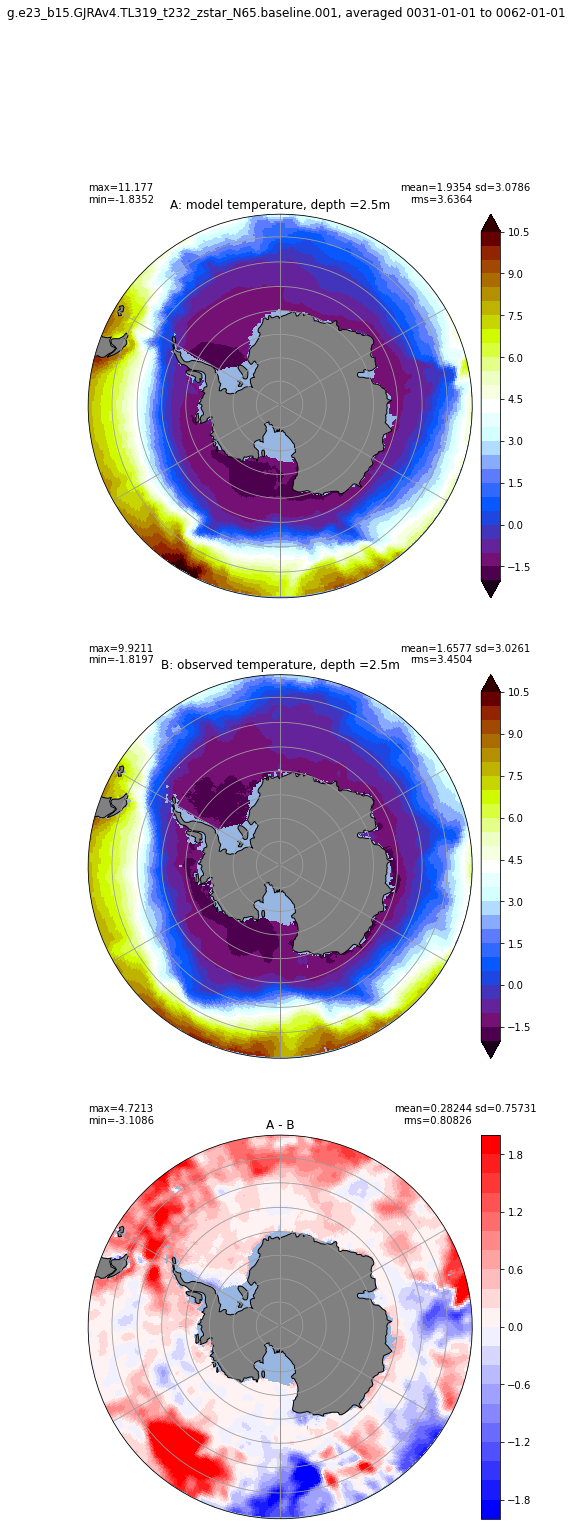

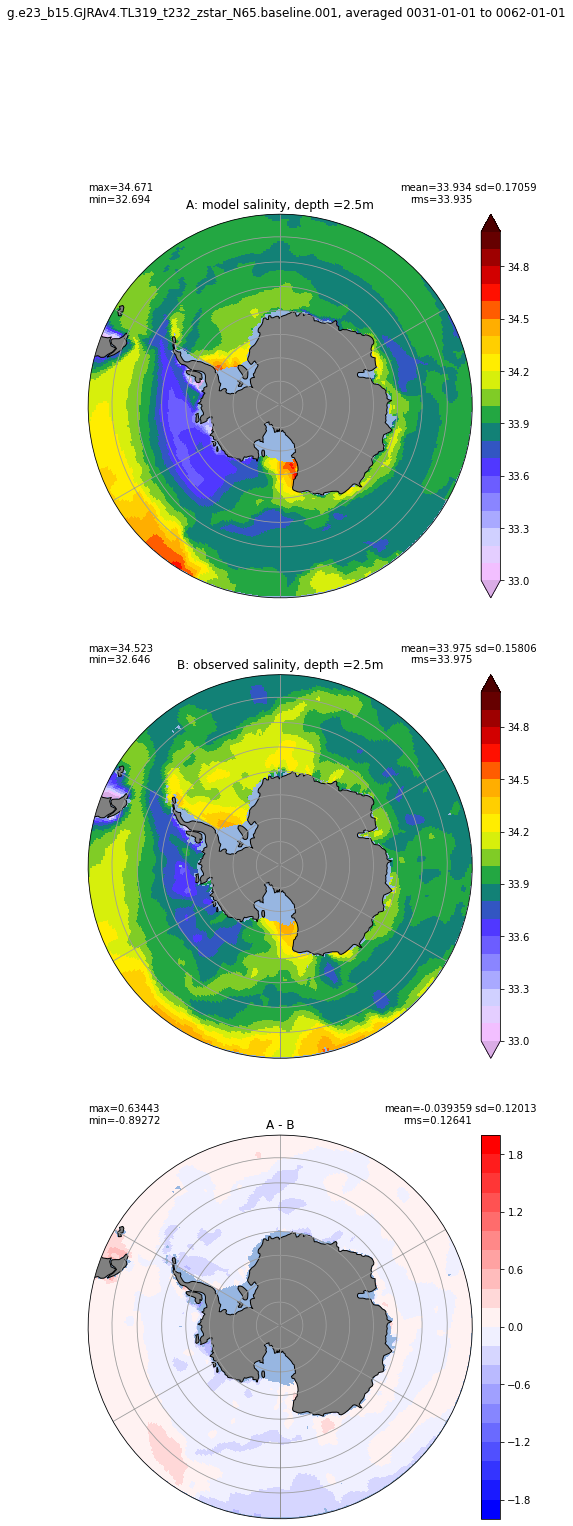

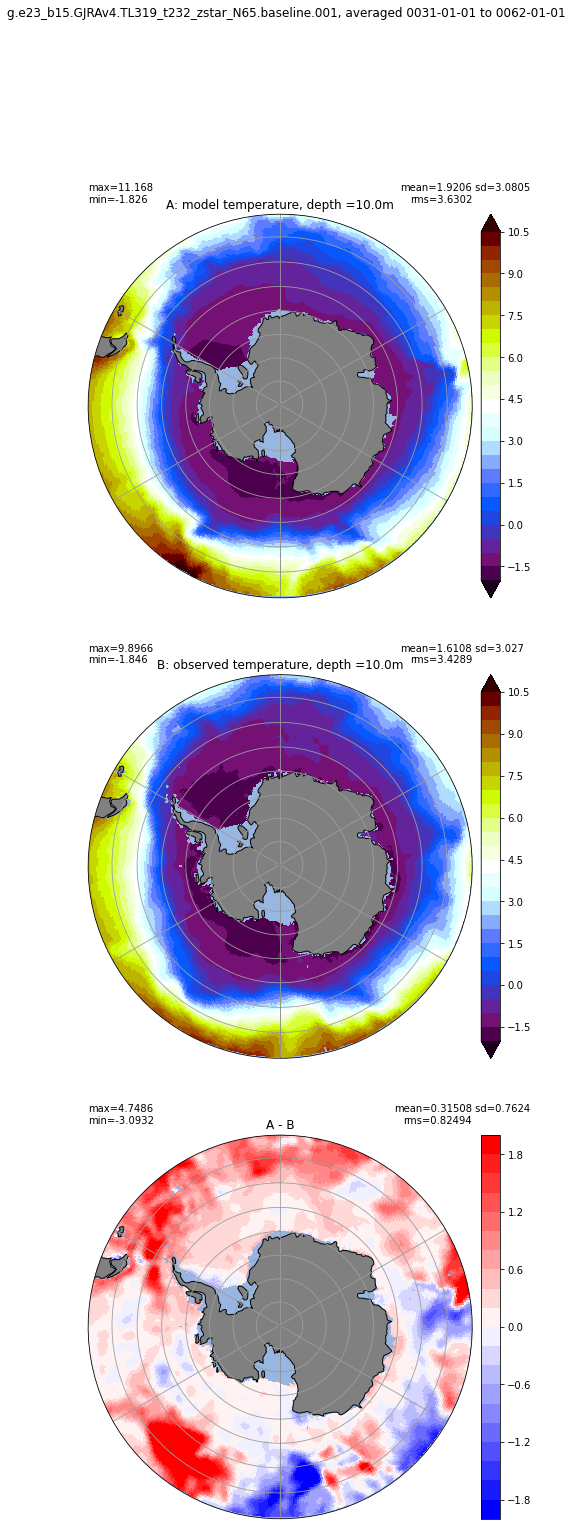

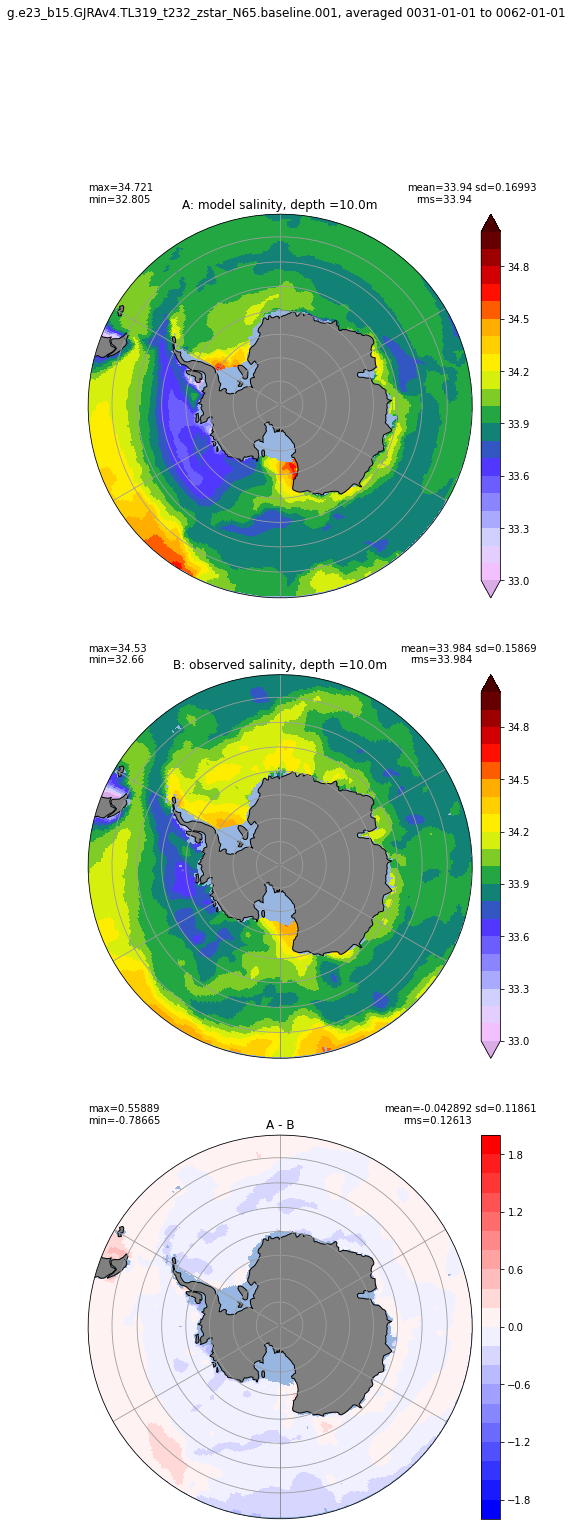

In [ ]:
# loop over depths and compare TS fields
km = len(woa18['depth'])
for k in range(km):
  if (ds['z_l'][k].values < 100.):
    temp_obs = np.ma.masked_invalid(woa18['thetao'][k,:].values)
    polarcomparison(temp[k,:] , temp_obs, grd,
              title1 = 'model temperature, depth ='+str(ds['z_l'][k].values)+ 'm',
              title2 = 'observed temperature, depth ='+str(woa18['depth'][k].values)+ 'm',
              extend='both', dextend='neither', clim=(-1.9,10.5), dlim=(-2,2), dcolormap=plt.cm.bwr,
              suptitle=dcase.casename + ', averaged '+str(args.start_date)+ ' to ' +str(args.end_date),
              proj='SP', show= True)

    salt_obs = np.ma.masked_invalid(woa18['so'][k,:].values)
    polarcomparison( salt[k,:] , salt_obs, grd,
              title1 = 'model salinity, depth ='+str(ds['z_l'][k].values)+ 'm',
              title2 = 'observed salinity, depth ='+str(woa18['depth'][k].values)+ 'm',
              extend='both', dextend='neither', clim=(33.,35.), dlim=(-2,2), dcolormap=plt.cm.bwr,
              suptitle=dcase.casename + ', averaged '+str(args.start_date)+ ' to ' +str(args.end_date),
              proj='SP', show= True)

## Arctic

In [ ]:
# loop over depths and compare TS fields
km = len(woa18['depth'])
for k in range(km):
  if (ds['z_l'][k].values < 100.):
    temp_obs = np.ma.masked_invalid(woa18['thetao'][k,:].values)
    polarcomparison(temp[k,:] , temp_obs, grd,
            title1 = 'model temperature, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed temperature, depth ='+str(woa18['depth'][k].values)+ 'm',
            extend='both', dextend='neither', clim=(-1.9,10.5), dlim=(-2,2), dcolormap=plt.cm.bwr,
            suptitle=dcase.casename + ', averaged '+str(args.start_date)+ ' to ' +str(args.end_date),
            proj='NP', show= True)

   
    salt_obs = np.ma.masked_invalid(woa18['so'][k,:].values)
    polarcomparison( salt[k,:] , salt_obs, grd,
            title1 = 'model salinity, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed salinity, depth ='+str(woa18['depth'][k].values)+ 'm',
            extend='both', dextend='neither', clim=(32.,34.5), dlim=(-2,2), dcolormap=plt.cm.bwr,
            suptitle=dcase.casename + ', averaged '+str(args.start_date)+ ' to ' +str(args.end_date),
            proj='NP', show= True)